In [ ]:
# Import libraries
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda ,Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
import torch.autograd as autograd
import seaborn as sns

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = True if torch.cuda.is_available() else False
lambda_gp = 10
n_epochs = 200
sample_interval = 200
batch_size = 64
learning_rate = 0.0002
b1 = 0.5     #decay of first order momentum of gradient
b2 = 0.999   #decay of first order momentum of gradient
img_size = 64
channels_img =1
features_g = 64
features_dis = 64
z_dim = 128
critic_iter = 5 #number of training steps for discriminator per iteration
img_shape = (channels_img, img_size,img_size)
Latent_dim = 1


In [ ]:
NUM_BATCHES = 600
BATCH_SIZE = 512
PLOT_EVERY = 1
GRID_RESOLUTION = 400
LATENT_DIM = 1

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, layers, output_activation=None):
        """A generator for mapping a latent space to a sample space.
        Args:
            latent_dim (int): latent dimension ("noise vector")
            layers (List[int]): A list of layer widths including output width
            output_activation: torch activation function or None
        """
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_activation = output_activation
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.latent_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.ReLU())
        

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_dim, layers):
        """A discriminator for discerning real from generated samples.
        params:
            input_dim (int): width of the input
            layers (List[int]): A list of layer widths including output width
        Output activation is Sigmoid.
        """
        super(Critic, self).__init__()
        self.input_dim = input_dim
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.input_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
               print(len(layers))
               self.module_list.append(nn.ReLU())
               
            else:
               self.module_list.append(nn.Linear(last_layer, 1)) #remove sigmoid activation for wgan-gp

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate


In [ ]:
class WGAN():
    def __init__(self, generator, critic, noise_fn, data_fn,
                 batch_size=32, device='cuda', lr_d=1e-3, lr_g=2e-4):
        """
        Args:
            generator: a Ganerator network
            critic: A Critic network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = generator
        self.generator = self.generator.to(device)
        self.critic = critic
        self.critic = self.critic.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
       
        self.batch_size = batch_size
        #self.train_step = train_step
        self.device = device
        #self.criterion = nn.BCELoss() #different criterion
        self.optim_d = optim.Adam(critic.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
       
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        loss = - torch.mean(generated)
        loss.backward()
        self.optim_g.step()
        return loss.item()
        
    def train_step_critic(self):
        """Train the discriminator one step and return the losses."""
        self.critic.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        #pred_real = self.discriminator(real_samples

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
       
        critic_real = self.critic(real_samples)
        critic_fake = self.critic(fake_samples)

        
        loss_critic =  -(torch.mean(critic_real) - torch.mean(critic_fake)) 
            
        
        loss_critic.backward()
        self.optim_d.step()
        return loss_critic.item()

    def train_step(self):
        loss_c = self.train_step_critic()
        loss_g = self.train_step_generator()
        return loss_g, loss_c


In [ ]:
def main():
    from time import time
    epochs = 200
    batches = 100
    weight_clip = 0.01
    CRITIC_ITERATIONS=5
    gen = Generator(1, [64, 32, 1])
    critic= Critic(1, [64, 32, 1])

    noise_fn = lambda x: torch.rand((x, 1), device='cpu')
    data_fn = lambda x: torch.randn((x, 1), device='cpu')
    epsilon= lambda x: torch.rand((x,0.2), device= 'cpu', requires_grad=True)

    wgan = WGAN(gen,critic, noise_fn, data_fn, device='cpu')

    gen.train()
    critic.train()

    loss_g, loss_c = [], []
    start = time()
    for epoch in range(epochs):
      
        loss_g_running = 0

        for batch in range(batches):
            loss_c_running = 0
            for _ in range(CRITIC_ITERATIONS):
                lc_ = wgan.train_step_critic()

                
            # clip critic weights between -0.01, 0.01
                for p in critic.parameters():
                    p.data.clamp_(-weight_clip,weight_clip)

            loss_c_running += lc_


        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
            lg_ = wgan.train_step_generator()
            loss_g_running += lg_
            
        loss_g.append(loss_g_running / batches)
        loss_c.append(loss_c_running / batches)
        
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" G={loss_g[-1]:.3f},"
              f" C={loss_c[-1]:.3f},"
             )


if __name__ == "__main__":
    main()

3
3
Epoch 1/200 (0s): G=-0.516, C=-0.000,
Epoch 2/200 (1s): G=-1.750, C=-0.000,
Epoch 3/200 (2s): G=-3.907, C=-0.000,
Epoch 4/200 (2s): G=-7.368, C=-0.000,
Epoch 5/200 (3s): G=-12.509, C=-0.000,
Epoch 6/200 (4s): G=-19.589, C=-0.000,
Epoch 7/200 (4s): G=-28.897, C=-0.000,
Epoch 8/200 (5s): G=-40.651, C=-0.000,
Epoch 9/200 (6s): G=-55.065, C=-0.000,
Epoch 10/200 (6s): G=-72.417, C=-0.000,
Epoch 11/200 (7s): G=-92.832, C=-0.000,
Epoch 12/200 (8s): G=-116.226, C=-0.000,
Epoch 13/200 (9s): G=-142.829, C=-0.000,
Epoch 14/200 (9s): G=-172.632, C=-0.000,
Epoch 15/200 (10s): G=-205.564, C=-0.000,
Epoch 16/200 (11s): G=-243.127, C=-0.000,
Epoch 17/200 (11s): G=-285.075, C=-0.000,
Epoch 18/200 (12s): G=-331.610, C=-0.000,
Epoch 19/200 (13s): G=-377.618, C=-0.000,
Epoch 20/200 (13s): G=-433.137, C=-0.000,
Epoch 21/200 (14s): G=-488.523, C=-0.000,
Epoch 22/200 (15s): G=-547.060, C=-0.000,
Epoch 23/200 (16s): G=-615.289, C=-0.000,
Epoch 24/200 (16s): G=-680.624, C=-0.000,
Epoch 25/200 (17s): G=-759

4
4
4
0


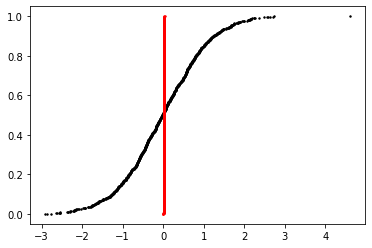

1


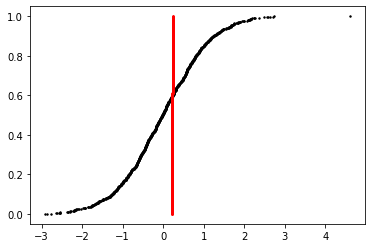

2


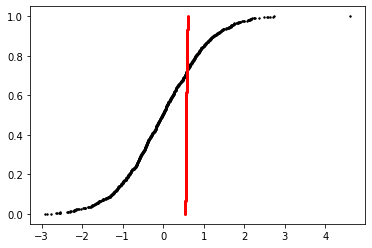

3


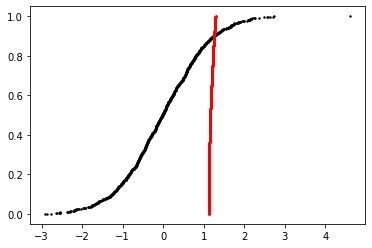

4


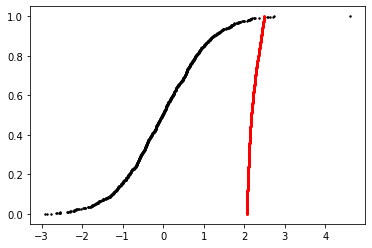

5


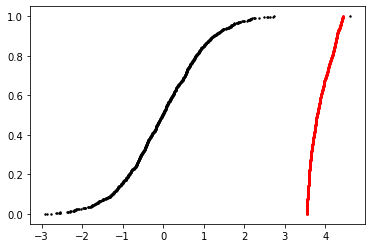

6


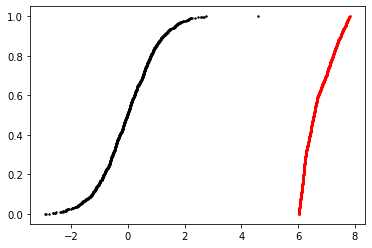

7


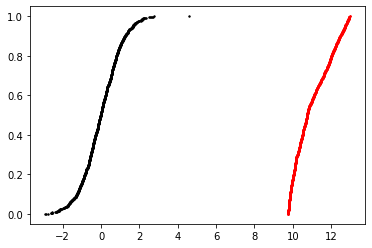

8


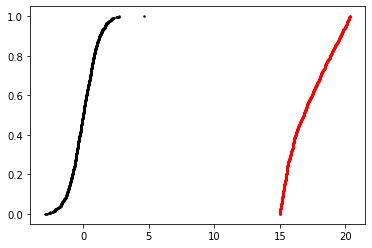

9


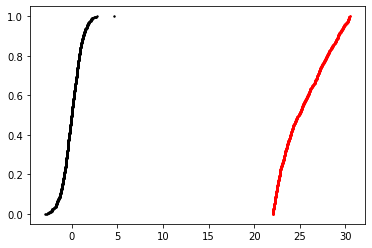

10


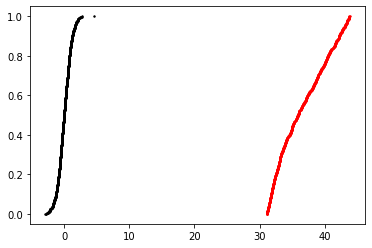

11


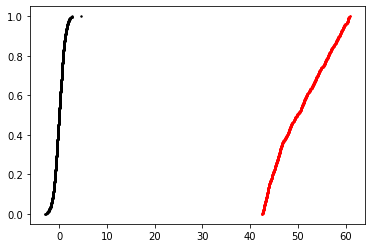

12


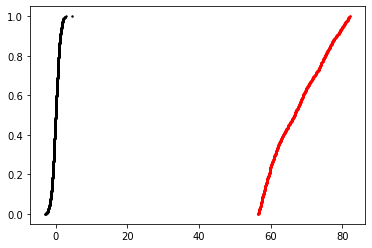

13


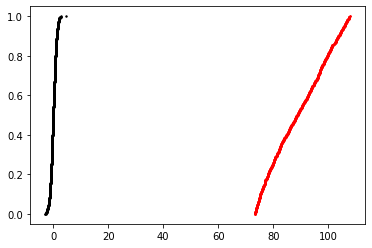

14


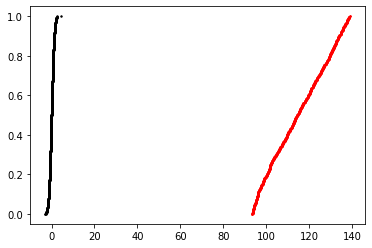

15


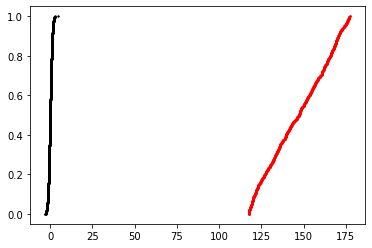

16


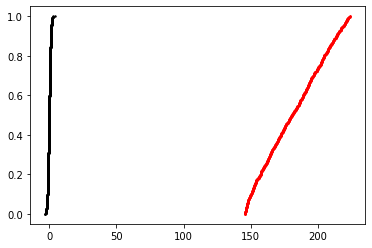

17


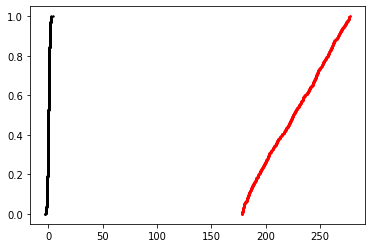

18


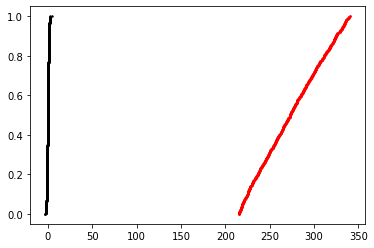

19


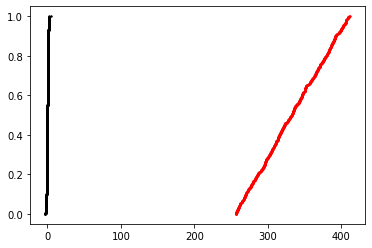

20


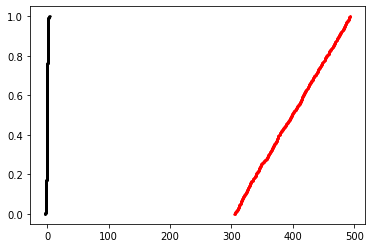

21


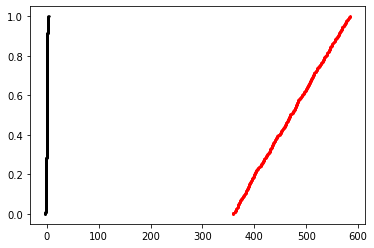

22


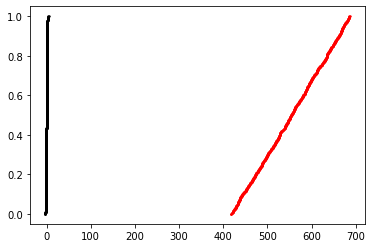

23


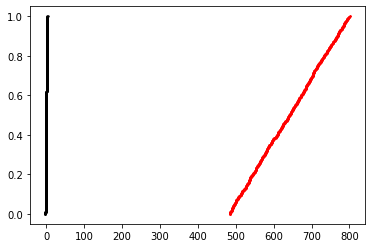

24


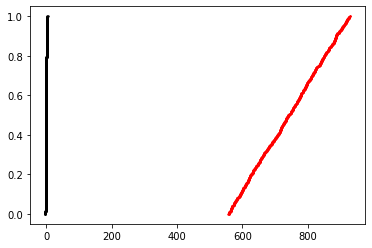

25


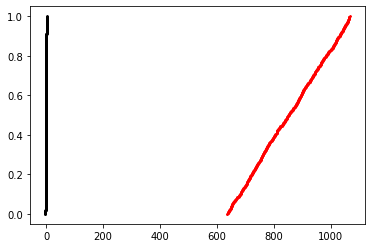

26


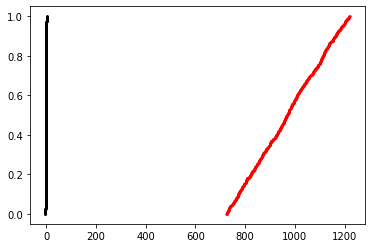

27


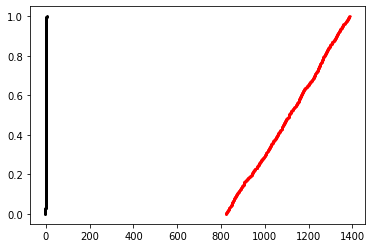

28


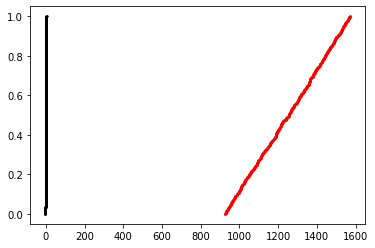

29


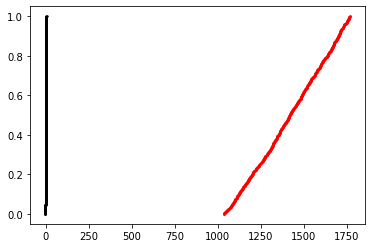

30


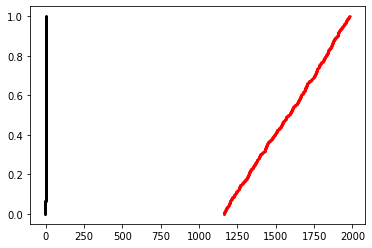

31


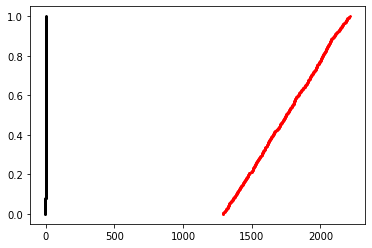

32


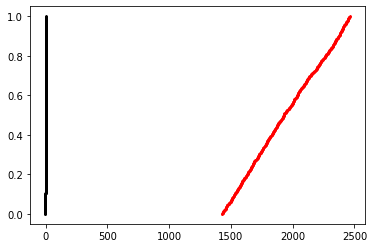

33


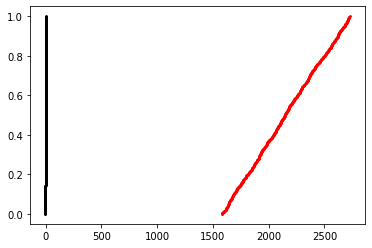

34


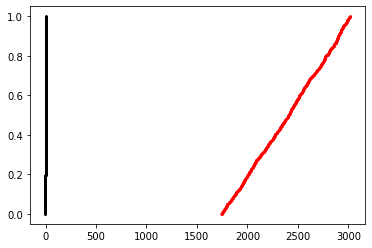

35


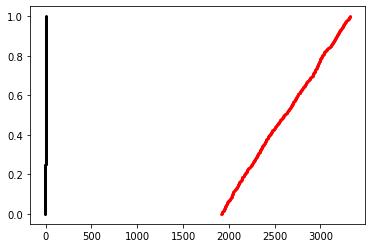

36


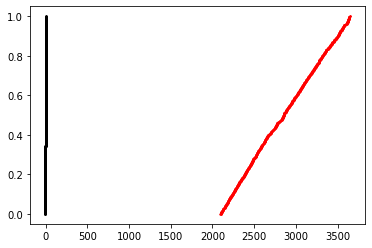

37


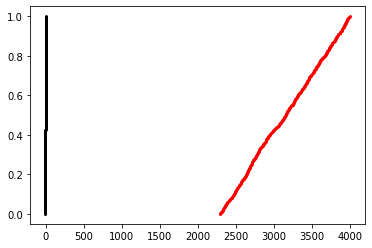

38


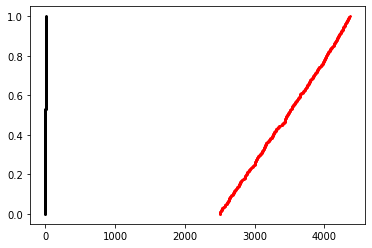

39


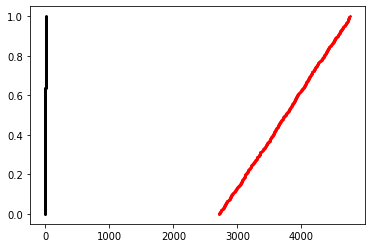

40


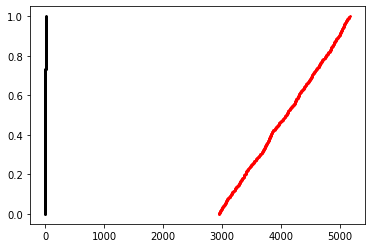

41


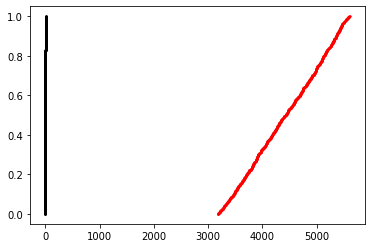

42


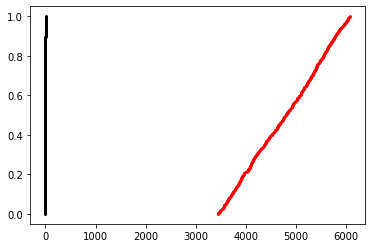

43


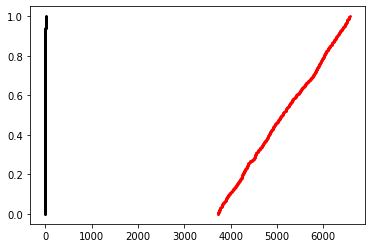

44


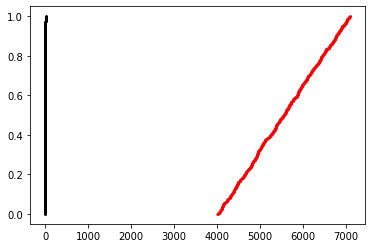

45


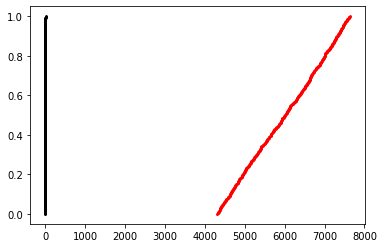

46


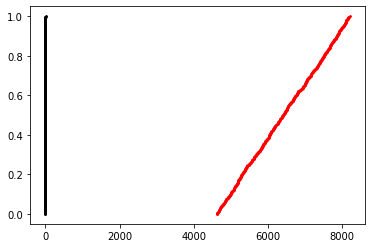

47


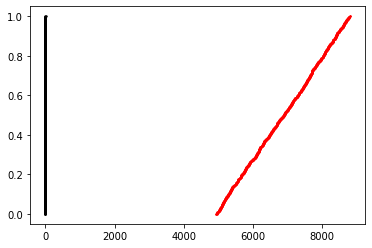

48


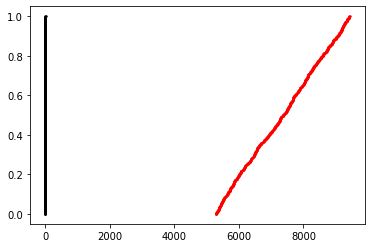

49


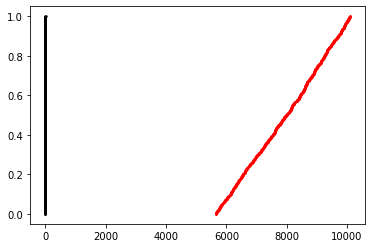

50


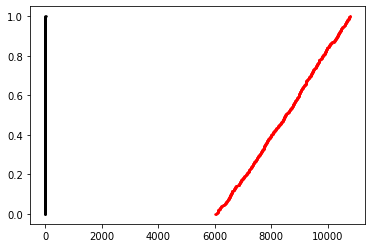

51


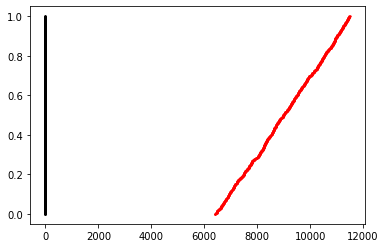

52


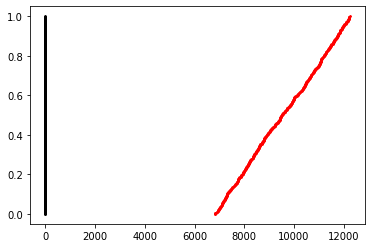

53


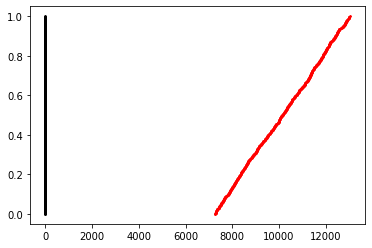

54


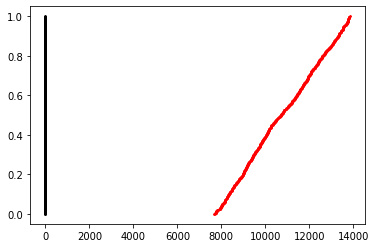

55


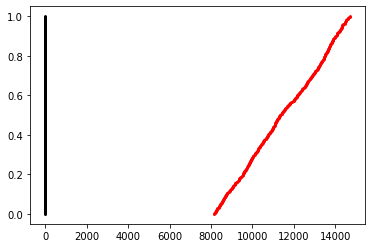

56


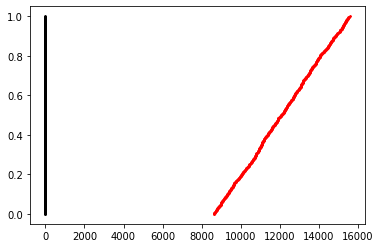

57


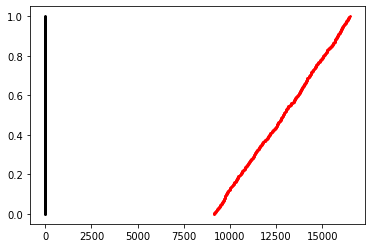

58


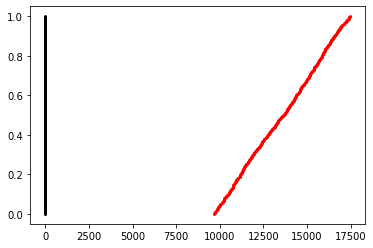

59


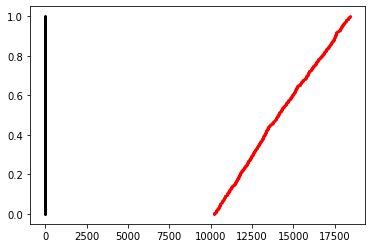

60


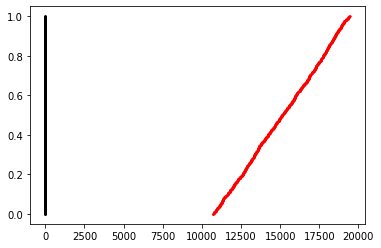

61


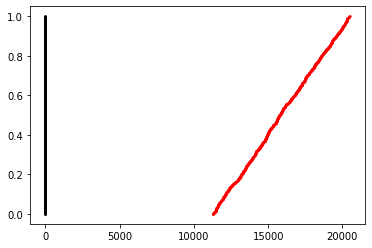

62


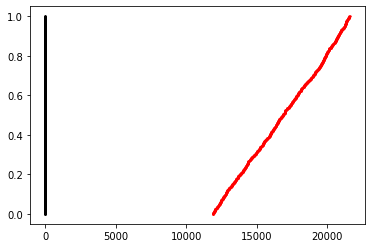

63


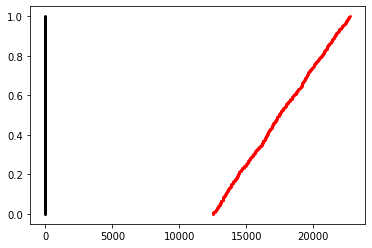

64


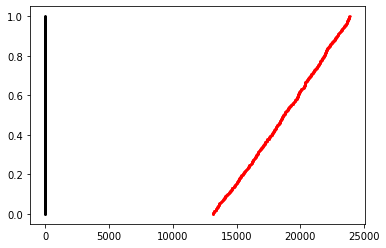

65


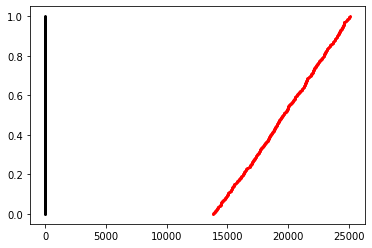

66


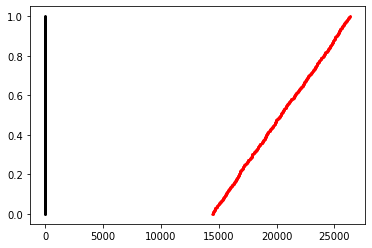

67


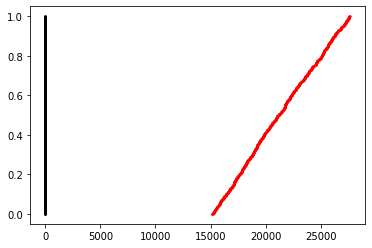

68


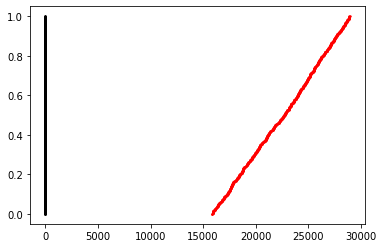

69


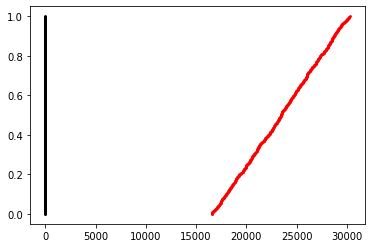

70


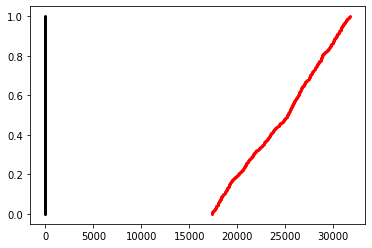

71


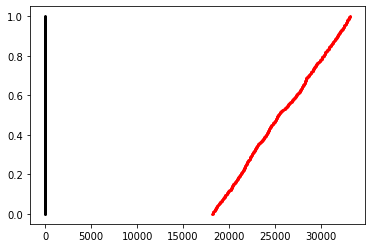

72


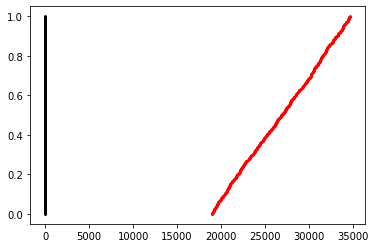

73


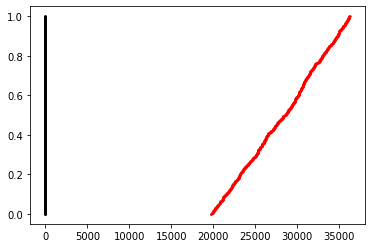

74


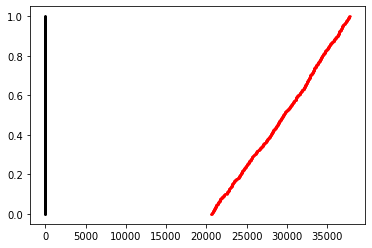

75


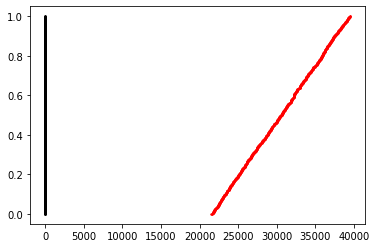

76


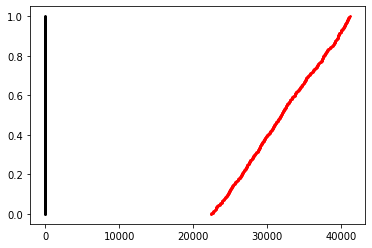

77


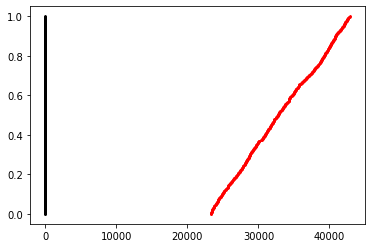

78


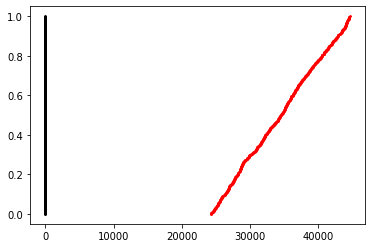

79


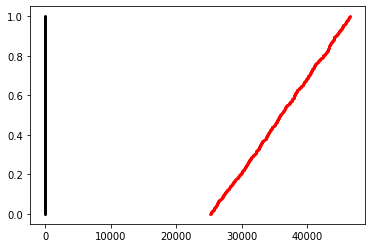

80


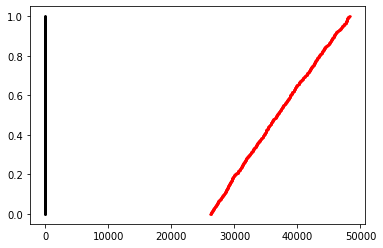

81


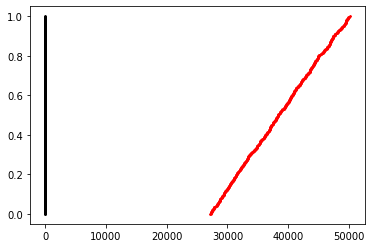

82


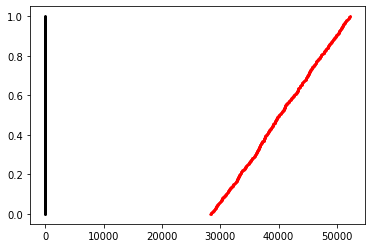

83


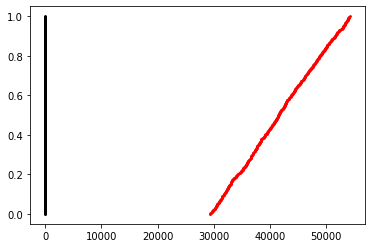

84


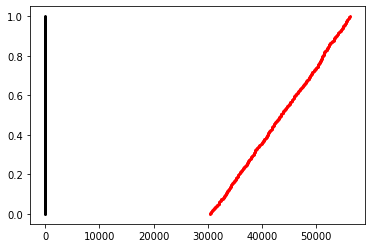

85


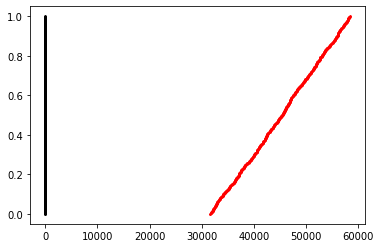

86


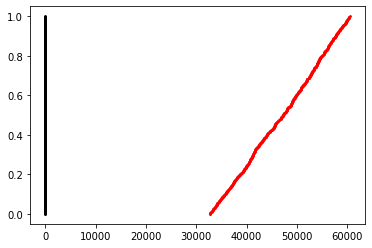

87


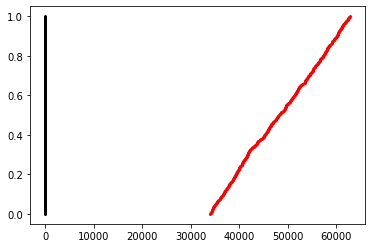

88


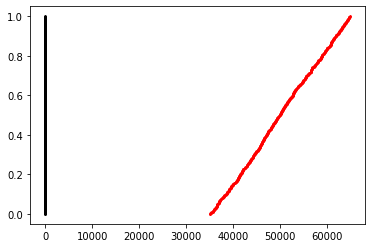

89


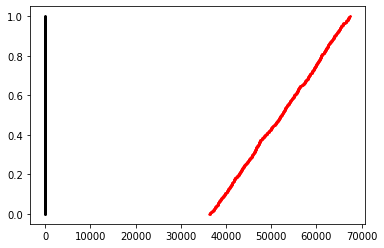

90


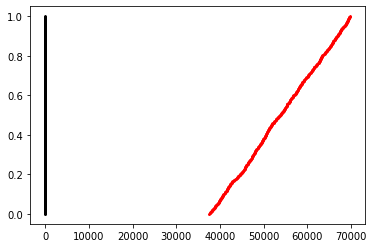

91


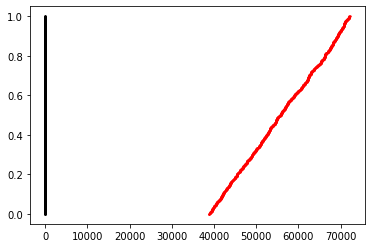

92


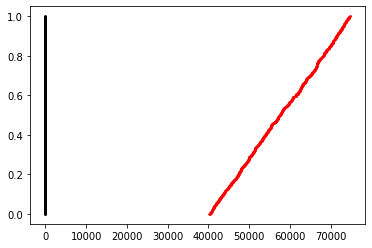

93


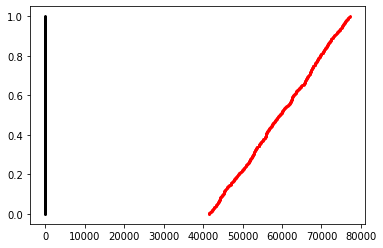

94


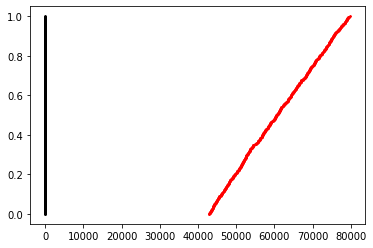

95


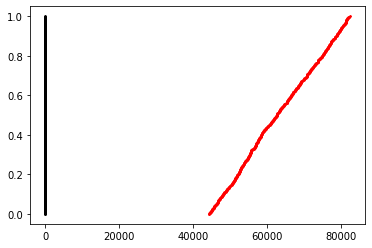

96


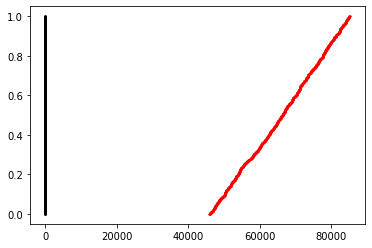

97


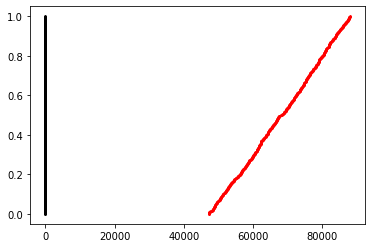

98


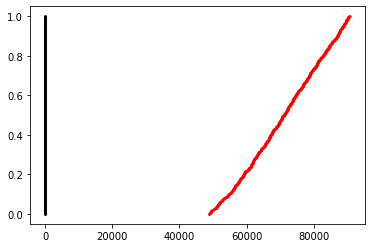

99


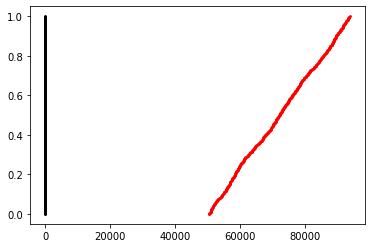

100


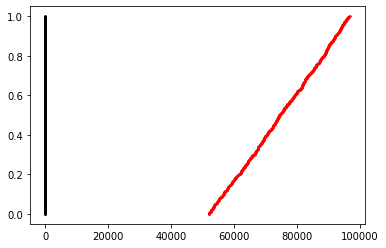

101


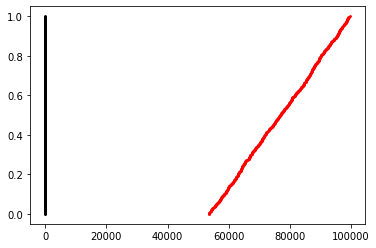

102


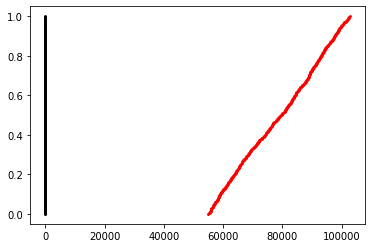

103


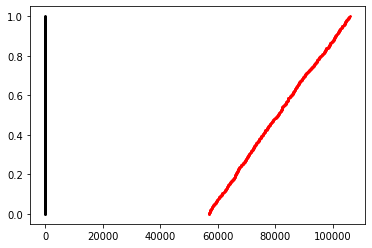

104


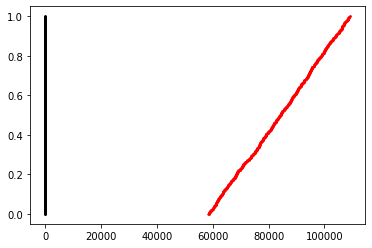

105


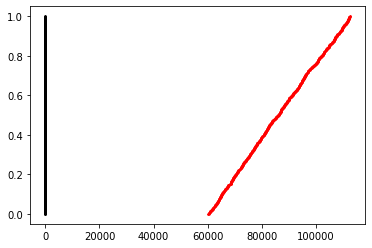

106


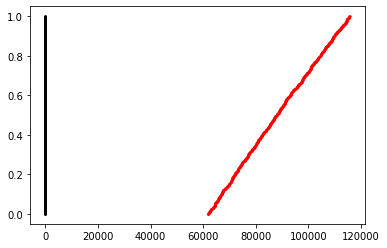

107


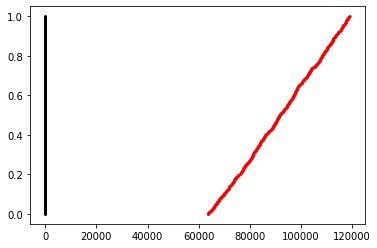

108


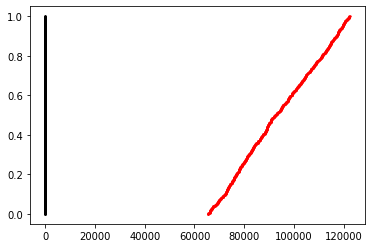

109


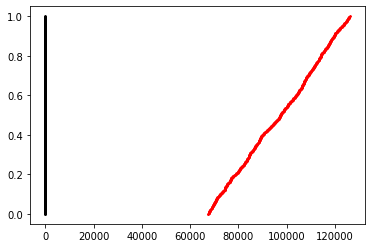

110


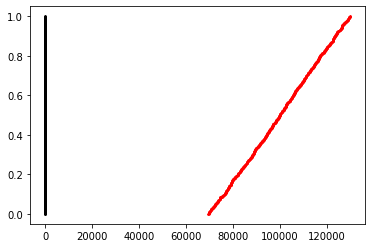

111


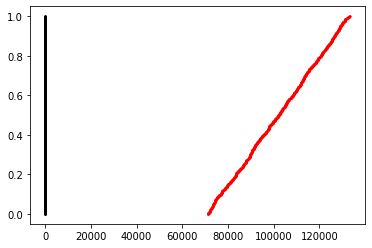

112


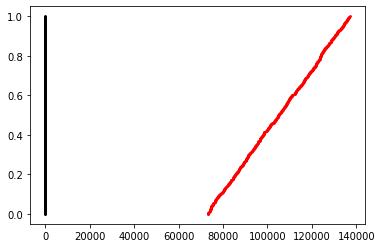

113


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def noise_fn(num):
    return torch.rand((num, LATENT_DIM), device=DEVICE)

def target_fn(num):
    return torch.randn((num, 1), device=DEVICE)

data_fn = lambda x: torch.randn((x, 1), device='cpu')
weight_clip = 0.01


gen = Generator(LATENT_DIM, [32, 32, 32, 1], output_activation=None)
critic = Critic(1, [32, 32, 32, 1])

wgan = WGAN(gen, critic, noise_fn, data_fn, device='cpu')

real_samples = np.random.normal(0, 1, 1000)
real_samples = np.sort(real_samples)
epsilon= torch.rand(32,1, requires_grad=True) #lambda x: torch.rand((x,0.2), device= 'cpu', requires_grad=True)
for i in range(500):
    print(i)
    for _ in range(50):
       for _ in range(5):
          wgan.train_step_critic()
          for p in critic.parameters():
                    p.data.clamp_(-weight_clip,weight_clip)

       
       wgan.train_step_generator()  
    generated_samples = wgan.generate_samples(num=1000).cpu().numpy().flatten()
    generated_samples = np.sort(generated_samples)
    plt.cla()
    plt.scatter(real_samples, np.linspace(0, 1, len(real_samples)), c='k', s=2)
    plt.scatter(generated_samples, np.linspace(0, 1, len(generated_samples)), c='r', s=2)
    plt.draw()
    plt.pause(0.001)
input()